In [1]:
import os
from utils.retina import RetinaNet, FocalLoss, get_backbone
from utils.generator import (LabelEncoder, preprocess_data, 
                             preprocess_data_from_textline, 
                             preprocess_data_from_tfrecord)
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.data import TextLineDataset, TFRecordDataset
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
# from tensorflow.optimizers.schedules import PiecewiseConstantDecay
import zipfile

import pdb

In [2]:
train_dataset  = TextLineDataset(filenames='data/annot_train.txt')
train_path = "C:/Users/HP/work/data/image/synthetic/train"

In [3]:
autotune = tf.data.experimental.AUTOTUNE
# train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.map(lambda x: preprocess_data_from_textline(x, train_path),
                                  num_parallel_calls=autotune)

In [4]:
for x in train_dataset.take(1):
    print(x)

(<tf.Tensor: shape=(896, 896, 3), dtype=float32, numpy=
array([[[ 80.47112 ,  72.258705,  85.25882 ],
        [ 44.274704,  24.479034,  43.67937 ],
        [ 84.695274,  44.9487  ,  71.58823 ],
        ...,
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ]],

       [[ 78.972374,  65.62121 ,  72.18025 ],
        [ 81.40836 ,  65.54099 ,  75.048096],
        [119.93312 , 100.64027 , 114.38141 ],
        ...,
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ]],

       [[ 55.167053,  35.524033,  29.83268 ],
        [ 72.3165  ,  65.66499 ,  57.80213 ],
        [ 66.83413 ,  87.89012 ,  75.55999 ],
        ...,
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ]],

       ...,

       [[  0.      ,   0.      ,   0.      ],
        [  0

In [5]:
x[1]

<tf.Tensor: shape=(14, 4), dtype=float32, numpy=
array([[115.89635 , 542.1884  ,  87.20916 ,  83.76669 ],
       [871.5177  , 313.83817 ,  72.29181 ,  65.40686 ],
       [ 86.06166 , 160.64842 ,  82.61922 ,  84.91418 ],
       [466.45416 , 150.32103 , 104.42148 , 105.56898 ],
       [434.89822 , 873.8126  ,  73.43927 ,  79.1767  ],
       [881.27136 , 472.1916  , 103.27399 ,  88.35666 ],
       [468.74918 , 591.5304  ,  92.946594,  90.65155 ],
       [154.91096 , 284.5772  ,  75.73428 ,  71.14429 ],
       [838.8143  , 740.13025 ,  96.38904 ,  96.3891  ],
       [199.0893  , 131.38745 ,  81.47171 ,  79.17671 ],
       [892.1725  , 117.61759 ,  81.47168 ,  81.471695],
       [673.57587 , 627.10254 ,  82.61914 ,  76.881775],
       [656.9373  , 344.2466  ,  76.881714,  82.6192  ],
       [626.5289  , 204.82674 ,  87.20911 ,  90.65161 ]], dtype=float32)>

In [6]:
x[1].shape

TensorShape([14, 4])

In [7]:
x[2]

<tf.Tensor: shape=(14,), dtype=int32, numpy=array([2, 2, 4, 3, 2, 3, 1, 3, 3, 4, 2, 2, 2, 4])>

In [5]:
label_encoder = LabelEncoder()

In [7]:
batch_size = 1
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(batch_size=batch_size, 
                                           padding_values=(0.0, 1e-8, -1), 
                                           drop_remainder=True)
train_dataset = train_dataset.map(label_encoder.encode_batch, 
                                  num_parallel_calls=autotune)

In [8]:
for x in train_dataset.take(1):
    print(x[0].shape, x[1].shape)

(1, 896, 896, 3) (1, 150381, 5)


In [10]:
x[1][0][25]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([12.85818   ,  9.855706  ,  0.98941976,  4.455155  , -1.        ],
      dtype=float32)>

In [2]:
def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.

    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.

    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

In [3]:
def swap_xy1(boxes):
    xmin, ymin, xmax, ymax = tf.split(boxes, 4, axis=-1)
    new_boxes = tf.concat([ymin, xmin, ymax, xmax], axis=-1)
    return new_boxes

def convert_to_xywh1(boxes):
    cxcy = (boxes[..., :2] + boxes[..., 2:]) * 0.5
    wh = boxes[..., 2:] - boxes[..., :2]
    new_boxes = tf.concat([cxcy, wh], axis=-1)
    return new_boxes

def convert_to_corners1(boxes):
    xy_min = boxes[..., :2] - boxes[..., 2:] * 0.5
    xy_max = xy_min + boxes[..., 2:]    
    new_boxes = tf.concat([xy_min, xy_max], axis=-1)
    return new_boxes

In [6]:
boxes1 = tf.constant([[100, 110, 30, 50],
                      [50, 60, 45, 28]], dtype=tf.float32)

In [7]:
swap_xy(boxes1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[110., 100.,  50.,  30.],
       [ 60.,  50.,  28.,  45.]], dtype=float32)>

In [8]:
swap_xy1(boxes1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[110., 100.,  50.,  30.],
       [ 60.,  50.,  28.,  45.]], dtype=float32)>

In [9]:
convert_to_corners(boxes1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 85. ,  85. , 115. , 135. ],
       [ 27.5,  46. ,  72.5,  74. ]], dtype=float32)>

In [10]:
convert_to_corners1(boxes1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 85. ,  85. , 115. , 135. ],
       [ 27.5,  46. ,  72.5,  74. ]], dtype=float32)>

In [11]:
convert_to_xywh(boxes1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 65. ,  80. , -70. , -60. ],
       [ 47.5,  44. ,  -5. , -32. ]], dtype=float32)>

In [12]:
convert_to_xywh1(boxes1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 65. ,  80. , -70. , -60. ],
       [ 47.5,  44. ,  -5. , -32. ]], dtype=float32)>

In [13]:
boxes2 = tf.constant([[145, 150, 30, 20]], dtype=tf.float32)

In [14]:
def compute_iou(boxes1, boxes2):
    """Computes pairwise IOU matrix for given two sets of boxes

    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.

    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


In [15]:
def compute_iou1(boxes1, boxes2):
    # boxes are in format [x, y, w, h]
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0) 

In [16]:
compute_iou(boxes1, boxes2)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>

In [17]:
compute_iou1(boxes1, boxes2)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>

In [68]:
convert_to_conners(boxes1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 85. ,  85. , 115. , 135. ],
       [ 27.5,  46. ,  72.5,  74. ]], dtype=float32)>

In [72]:
def convert_to_corners(boxes):
    xymin = boxes[:, :2] - boxes[:, 2:] * 0.5
    xymax = xymin + boxes[:, 2:]
    new_boxes = tf.concat([xymin, xymax], axis=-1)
    return new_boxes

In [47]:
boxes1_conner = convert_to_conners(boxes1)

In [48]:
boxes1_conner

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 85. ,  85. , 115. , 135. ],
       [ 27.5,  46. ,  72.5,  74. ]], dtype=float32)>

In [49]:
boxes2_conner = convert_to_conners(boxes2)
boxes2_conner

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[130., 140., 160., 160.]], dtype=float32)>

In [54]:
a = boxes1_conner[:, None, :2]
a

<tf.Tensor: shape=(2, 1, 2), dtype=float32, numpy=
array([[[85. , 85. ]],

       [[27.5, 46. ]]], dtype=float32)>

In [55]:
b = boxes2_conner[:, :2]
b

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[130., 140.]], dtype=float32)>

In [58]:
tf.maximum(a, b)

<tf.Tensor: shape=(2, 1, 2), dtype=float32, numpy=
array([[[130., 140.]],

       [[130., 140.]]], dtype=float32)>

In [60]:
d = tf.maximum(boxes1_conner[:, None, 2:], boxes2_conner[:, 2:])
d

<tf.Tensor: shape=(2, 1, 2), dtype=float32, numpy=
array([[[160., 160.]],

       [[160., 160.]]], dtype=float32)>

In [62]:
intersection = tf.maximum(0.0, d - c)
intersection

<tf.Tensor: shape=(2, 1, 2), dtype=float32, numpy=
array([[[30., 20.]],

       [[30., 20.]]], dtype=float32)>

In [63]:
intersection_area = intersection[..., 0] * intersection[..., 1]
intersection_area

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[600.],
       [600.]], dtype=float32)>

In [64]:
boxes1_area = boxes1[:, 2] * boxes1[:, 3]
boxes2_area = boxes2[:, 2] * boxes2[:, 3]
union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
)

In [65]:
union_area

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1500.],
       [1260.]], dtype=float32)>

In [70]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [78]:
def visualize_detections(image, boxes, classes, 
                         scores, figsize=(7, 7), 
                         linewidth=1, color=[0, 0, 1]):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [75]:
classes = ['A', 'B', 'C']
scores = [30, 20, 50]

In [76]:
nimg = np.random.rand(224, 224, 3)

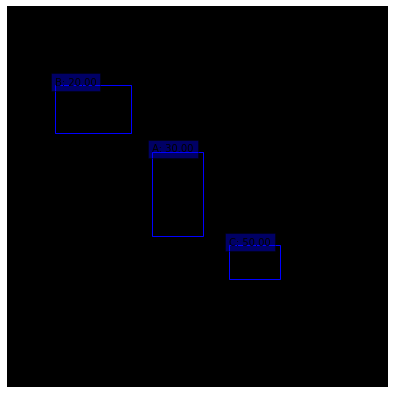

In [83]:
visualize_detections(nimg, abb, classes, scores)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


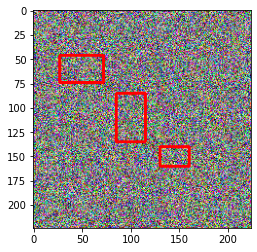

In [80]:
# img = cv.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0 , 0), 2)
plt.imshow(img)

In [82]:
abb = tf.concat([boxes1_conner, boxes2_conner], axis=0)

In [84]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [85]:
ac = AnchorBox()

In [93]:
500 / (2 ** 3)

62.5

In [86]:
x = ac._compute_dims()

In [91]:
x[4]

<tf.Tensor: shape=(1, 1, 9, 2), dtype=float32, numpy=
array([[[[ 362.03867,  724.07733],
         [ 456.14014,  912.2803 ],
         [ 574.70056, 1149.4011 ],
         [ 512.     ,  512.     ],
         [ 645.0796 ,  645.0796 ],
         [ 812.7493 ,  812.7493 ],
         [ 724.07733,  362.03867],
         [ 912.2803 ,  456.14014],
         [1149.4011 ,  574.70056]]]], dtype=float32)>

In [94]:
def get_backbone():
    """Builds ResNet50 with pre-trained imagenet weights"""
    backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [97]:
from tensorflow import keras
class FeaturePyramid(keras.layers.Layer):
    """Builds the Feature Pyramid with the feature maps from the backbone.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [98]:
def build_head(output_filters, bias_init):
    """Builds the class/box predictions head.

    Arguments:
      output_filters: Number of convolution filters in the final layer.
      bias_init: Bias Initializer for the final convolution layer.

    Returns:
      A keras sequential model representing either the classification
        or the box regression head depending on `output_filters`.
    """
    head = keras.Sequential([keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())
    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [99]:
class RetinaNet(keras.Model):
    """A subclassed Keras model implementing the RetinaNet architecture.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, num_classes, backbone=None, **kwargs):
        super(RetinaNet, self).__init__(name="RetinaNet", **kwargs)
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

In [100]:
model = RetinaNet(4)

In [111]:
image = np.random.rand(1, 800, 800, 3)

In [107]:
image.dtype

dtype('float64')

In [108]:
img = tf.constant(image, dtype=tf.float32)

In [109]:
img.shape

TensorShape([1, 600, 800, 3])

In [105]:
optimizer = 'adam'
model.compile(loss='mce', optimizer=optimizer)

In [114]:
y = model(image)

In [115]:
y.shape

TensorShape([1, 120087, 8])

In [117]:
x = ac.get_anchors(800, 800)
x.shape

TensorShape([120087, 4])

In [118]:
md = FeaturePyramid()

In [119]:
y = md(image)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [121]:
for i in range(5):
    print(y[i].shape)

(1, 100, 100, 256)
(1, 50, 50, 256)
(1, 25, 25, 256)
(1, 13, 13, 256)
(1, 7, 7, 256)


In [128]:
from math import ceil
for g in [3, 4, 5, 6, 7]:
    print(ceil(800 / (2 ** g)))

100
50
25
13
7
